# EDA for the second challenge 

In [92]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import requests
import pickle 
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import geopandas as gpd
import osmium
import osmnx as ox



df = pd.read_csv('BusRoutes.txt', sep='|')

In [93]:
dfSenior = pd.read_csv('Senior_TIM_v1.txt', sep='|', encoding= 'unicode_escape')

joinedDf=dfSenior.merge(df)
joinedDf.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,8
1,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,85
2,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,8
3,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,85
4,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248,8


In [94]:
joinedDf.groupby("Region_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False)

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
Region_of_Origin,,,
R1 - AM Lisboa,6184,160,576.977871
R2 - AM Porto,3803,133,2435.724436


In [95]:
avg_sen_district_df = joinedDf.groupby("District_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False)
avg_sen_district_df.head(10)

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
District_of_Origin,,,
Lisboa,5916,158,628.158972
Porto,3777,133,2451.672828
Setúbal,2368,141,365.034285
Aveiro,32,16,272.407024


## Explore overpass API

In [6]:

overpass_url = "http://overpass-api.de/api/interpreter"
#overpass_query = """
#        [out:json];
#        area[name="Lisboa"][admin_level=2]->.search;
#        (node[amenity="bus_station"](area.search);
#         way[amenity="bus_station"](area.search);
#         rel[amenity="bus_station"](area.search);
#        );
#        out;
#"""


overpass_query = """
        [out:json];
        area[name="Lisboa"][admin_level=2]->.search;
        (node(area)[highway=bus_stop]->.all;
        rel(bn.all);
        node(r)->.b;
         way[amenity="bus_station"](area.search);
         rel[amenity="bus_station"](area.search);
         ( .all; - .b; );
        );
        out;
"""

response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

{'version': 0.6,
 'generator': 'Overpass API 0.7.56.9 76e5016d',
 'osm3s': {'timestamp_osm_base': '2021-04-15T23:43:18Z',
  'timestamp_areas_base': '2021-04-15T22:33:13Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': []}

### OSMnx Street Network

In [69]:
%%time

#tags = {'route' : 'bus'}
#G = ox.geometries_from_place("Lisboa, Portugal", tags = {'route' : 'bus'}) #returns nothing


G = ox.graph_from_place('Lisboa', network_type='drive_service', simplify=True, retain_all=False)


CPU times: user 16.5 s, sys: 136 ms, total: 16.7 s
Wall time: 39.7 s


In [71]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [72]:
print(f"Num nodes: {len(nodes)}, num edges: {len(edges)}")

Num nodes: 14377, num edges: 29583


In [73]:
nodes.head(8)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
21270959,38.757318,-9.165944,3,NaN,NaN,POINT (-9.16594 38.75732)
21270962,38.758035,-9.161733,3,NaN,NaN,POINT (-9.16173 38.75804)
21270969,38.763211,-9.136542,3,NaN,NaN,POINT (-9.13654 38.76321)
21272087,38.747959,-9.188383,3,NaN,NaN,POINT (-9.18838 38.74796)
21272088,38.747807,-9.188400,3,NaN,NaN,POINT (-9.18840 38.74781)
21424776,38.748798,-9.188087,3,NaN,NaN,POINT (-9.18809 38.74880)
21424795,38.747253,-9.189558,3,NaN,NaN,POINT (-9.18956 38.74725)
21424798,38.746832,-9.185338,3,NaN,NaN,POINT (-9.18534 38.74683)


In [74]:
edges.head(8)

osmid  oneway   lanes  \
u        v          key                                          
21270959 413210796  0                 22278074    True       3   
21270962 21270959   0    [22278074, 396719604]    True  [3, 4]   
21270969 412246923  0    [22278381, 410895670]    True       4   
21272087 2688293048 0                396882454   False     NaN   
         21272088   0                396882454   False     NaN   
21272088 4001122643 0                  4515057    True     NaN   
         21272087   0                396882454   False     NaN   
         3997297372 0                396882454   False     NaN   

                                                                name  \
u        v          key                                                
21270959 413210796  0    Avenida General Norton de Matos/2ª Circular   
21270962 21270959   0    Avenida General Norton de Matos/2ª Circular   
21270969 412246923  0    Avenida Marechal Craveiro Lopes/2ª Circular   
21272087 2688293048 0              Rua Professor Reinaldo dos Santos   
         21272088   0              Rua Professor Reinaldo dos Santos   
21272088 4001122643 0                 Rua Manuel Ferreira de Andrade   
         21272087   0              Rua Professor Reinaldo dos Santos   
         3997297372 0              Rua Professor Reinaldo dos Santos   

                             highway maxspeed   length  \
u        v          key                                  
21270959 413210796  0          trunk       80   44.832   
21270962 21270959   0          trunk       80  375.295   
21270969 412246923  0          trunk       80  738.090   
21272087 2688293048 0    residential      NaN   82.536   
         21272088   0    residential      NaN   16.908   
21272088 4001122643 0    residential      NaN   15.771   
         21272087   0    residential      NaN   16.908   
         3997297372 0    residential      NaN   37.308   

                                                                  geometry  \
u        v          key                                                      
21270959 413210796  0    LINESTRING (-9.16594 38.75732, -9.16646 38.75730)   
21270962 21270959   0    LINESTRING (-9.16173 38.75804, -9.16283 38.757...   
21270969 412246923  0    LINESTRING (-9.13654 38.76321, -9.13828 38.763...   
21272087 2688293048 0    LINESTRING (-9.18838 38.74796, -9.18832 38.748...   
         21272088   0    LINESTRING (-9.18838 38.74796, -9.18840 38.747...   
21272088 4001122643 0    LINESTRING (-9.18840 38.74781, -9.18822 38.74779)   
         21272087   0    LINESTRING (-9.18840 38.74781, -9.18840 38.747...   
         3997297372 0    LINESTRING (-9.18840 38.74781, -9.18842 38.747...   

                        junction bridge  ref access tunnel service width  
u        v          key                                                   
21270959 413210796  0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
21270962 21270959   0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
21270969 412246923  0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
21272087 2688293048 0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
         21272088   0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
21272088 4001122643 0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
         21272087   0        NaN    NaN  NaN    NaN    NaN     NaN   NaN  
         3997297372 0        NaN    NaN  NaN    NaN    NaN     NaN   NaN

In [75]:
G_projected = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(
    G_projected, nodes=True, edges=True)

edges_proj.crs


<Projected CRS: +proj=utm +zone=29 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

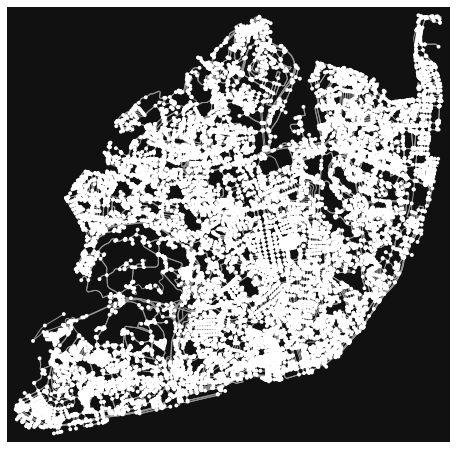

In [76]:
fig, ax = ox.plot_graph(G_projected)

In [77]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(G_projected, area=area)
stats

{'n': 14377,
 'm': 29583,
 'k_avg': 4.115323085483759,
 'intersection_count': 12106,
 'streets_per_node_avg': 2.8124782638937194,
 'streets_per_node_counts': {0: 0,
  1: 2271,
  2: 218,
  3: 9945,
  4: 1847,
  5: 76,
  6: 18,
  7: 0,
  8: 1,
  9: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1579606315643041,
  2: 0.015163107741531612,
  3: 0.6917298462822564,
  4: 0.1284690825624261,
  5: 0.0052862210475064335,
  6: 0.0012519997217778397,
  7: 0.0,
  8: 6.955554009876887e-05,
  9: 6.955554009876887e-05},
 'edge_length_total': 2280195.201999988,
 'edge_length_avg': 77.07788939593645,
 'street_length_total': 1565288.2079999887,
 'street_length_avg': 77.42052665941185,
 'street_segments_count': 20218,
 'node_density_km': 152.52080235415934,
 'intersection_density_km': 128.42852008760195,
 'edge_density_km': 24189.83110058723,
 'street_density_km': 16605.621019660746,
 'circuity_avg': 1.4574816920830468e-05,
 'self_loop_proportion': 0.00750430990771727,
 'clean_intersection_count': 

In [79]:
extended_stats = ox.extended_stats(G_projected, connectivity=True, ecc=False, cc=False)
series = pd.Series(extended_stats)
series

avg_neighbor_degree                    {21270959: 2.0, 413210796: 2.0, 21270962: 1.0,...
avg_neighbor_degree_avg                                                          2.21888
avg_weighted_neighbor_degree           {21270959: 0.04461099214846538, 413210796: 0.0...
avg_weighted_neighbor_degree_avg                                                0.056096
degree_centrality                      {21270959: 0.00020868113522537563, 413210796: ...
degree_centrality_avg                                                           0.000286
clustering_coefficient                 {21270959: 0, 413210796: 0, 21270962: 0, 21270...
clustering_coefficient_avg                                                      0.074897
clustering_coefficient_weighted        {21270959: 0, 413210796: 0, 21270962: 0, 21270...
clustering_coefficient_weighted_avg                                             0.001267
pagerank                               {21270959: 0.00015997003833364475, 413210796: ...
pagerank_max_node    

In [82]:


stats_columns = [
    'avg_neighbor_degree', 
    'degree_centrality', 
    'clustering_coefficient', 
    'pagerank'
]

series_list = [pd.Series(extended_stats[column_name], name=column_name).sort_index()
               for column_name in stats_columns]
series_list.append(nodes_proj['geometry'].sort_index())

gdf_stats = pd.concat(series_list, axis=1)

gdf_stats = gpd.GeoDataFrame(
    gdf_stats, geometry="geometry", crs=nodes_proj.crs)
gdf_stats.head(2)

,avg_neighbor_degree,degree_centrality,clustering_coefficient,pagerank,geometry
21270959,2.0,0.000209,0.0,0.000160,POINT (485581.631 4289859.567)
21270962,1.0,0.000209,0.0,0.000098,POINT (485947.661 4289938.486)


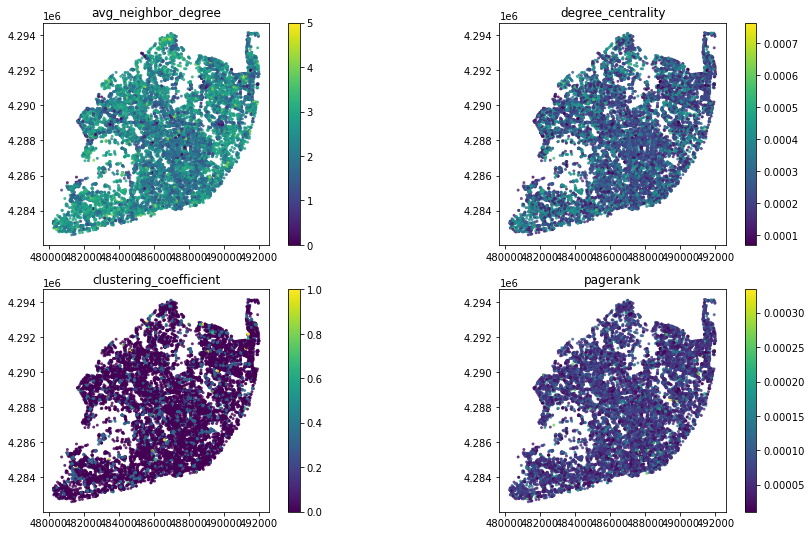

In [89]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 9))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats.plot(ax=ax, column=column_name, legend=True, s=4, alpha=0.7)
    ax.set_title(column_name)

## Use PyOsmium to get Amenities Information
Here we get Amenities Information from some districts based on the code presented in Workshop \#2 

We use only Lisbon and Porto because they are the only districts available at the [OSM Ready Extracts](https://download.bbbike.org/osm/bbbike/)

In [97]:
from collections import defaultdict

class AmenityStatsHandler(osmium.SimpleHandler):
    def __init__(self):
        super(AmenityStatsHandler, self).__init__()
        self.amenities = defaultdict(int)
    
    def node(self, n):
        for tag in n.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def way(self, w):
        for tag in w.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def relation(self, r):
        for tag in r.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

Download OpenStreetMap Extract

In [229]:
%%bash

FILE=Lisbon.osm.pbf
if  [[ -f "$FILE" ]]; then
    echo "$FILE already present."
else
    wget https://download.bbbike.org/osm/bbbike/Lisbon/Lisbon.osm.pbf \
    --quiet -O Lisbon.osm.pbf
fi

FILE=Porto.osm.pbf
if  [[ -f "$FILE" ]]; then
    echo "$FILE already present."
else
    wget https://download.bbbike.org/osm/bbbike/Porto/Porto.osm.pbf \
    --quiet -O Porto.osm.pbf
fi

In [230]:
src_filepath_lisboa = "Lisbon.osm.pbf"

handler_lisboa = AmenityStatsHandler()
handler_lisboa.apply_file(src_filepath_lisboa)

s_amenities_lisboa = pd.Series(handler_lisboa.amenities)



In [228]:
src_filepath_porto = "Porto.osm.pbf"

handler_porto = AmenityStatsHandler()
handler_porto.apply_file(src_filepath_porto)
s_amenities_porto = pd.Series(handler_porto.amenities)


In [132]:
#keep only certain amenities, namely the ones relating to mobility services or utilities:
mobility_amenities = ["bus_station", "ticket_validator", "motorcycle_parking", "parking", "parking_space", "taxi",\
"bicycle_rental", "bicycle_rental"]

#transform lisbon pd series to dataframe and keep only certain amenities
amenities_lisboa_df = pd.DataFrame({'amenity':s_amenities_lisboa.index, 'count':s_amenities_lisboa.values})
amenities_lisboa_df=amenities_lisboa_df[amenities_lisboa_df['amenity'].isin(mobility_amenities)]

#transform porto pd series to dataframe and keep only certain amenities
amenities_porto_df = pd.DataFrame({'amenity':s_amenities_porto.index, 'count':s_amenities_porto.values})
amenities_porto_df=amenities_porto_df[amenities_porto_df['amenity'].isin(mobility_amenities)]

#merge the 2 dataframes
amenities_lisboa_porto_df = pd.merge(left=amenities_lisboa_df, right=amenities_porto_df, how='left', left_on='amenity', right_on='amenity')
amenities_lisboa_porto_df.columns = ["amenity", "lisbon_count", "porto_count"]
amenities_lisboa_porto_df.head(10)

,amenity,lisbon_count,porto_count
0,parking,15652,4593
1,bus_station,70,44
2,taxi,113,71
3,bicycle_rental,168,16
4,parking_space,88,54
5,motorcycle_parking,80,3
6,ticket_validator,80,8


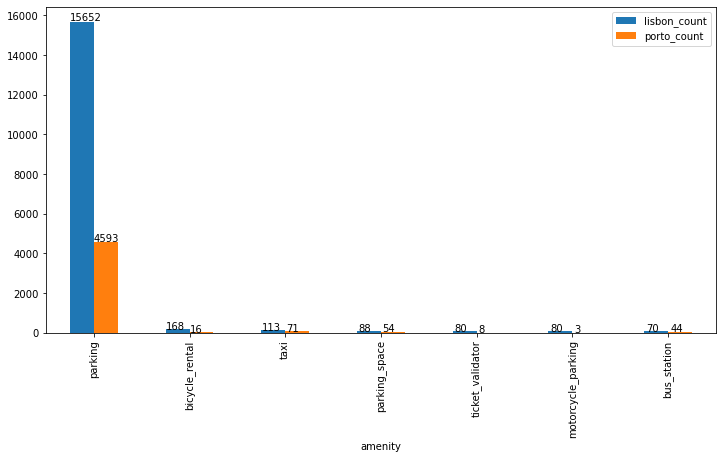

In [133]:
ax = amenities_lisboa_porto_df.sort_values(ascending=False, by=['lisbon_count', 'porto_count'])[:50] \
  .plot(kind='bar', figsize=(12, 6), x='amenity', y=["lisbon_count", "porto_count"]);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    

Unfortunately, we only have amenity data from Lisbon and Porto. Still, we try to analyze the influence on the ammount of certain amenities in both districts against the average of seniors travelling

In [134]:
amenities_seniors_df = pd.DataFrame(None, columns = ['District']+list(amenities_lisboa_porto_df.amenity.values))
amenities_seniors_df.loc[len(amenities_seniors_df)] = ['Lisboa']+list(amenities_lisboa_porto_df.lisbon_count.values)
amenities_seniors_df.loc[len(amenities_seniors_df)] = ['Porto']+list(amenities_lisboa_porto_df.porto_count.values)
amenities_seniors_df = pd.merge(left=amenities_seniors_df, right=avg_sen_district_df, how='left', left_on='District', right_on='District_of_Origin')

cols = amenities_seniors_df.columns.drop('District')
amenities_seniors_df[cols] = amenities_seniors_df[cols].apply(pd.to_numeric, errors='coerce')
amenities_seniors_df.head(40)

,District,parking,bus_station,taxi,bicycle_rental,parking_space,motorcycle_parking,ticket_validator,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
0,Lisboa,15652,70,113,168,88,80,80,5916,158,628.158972
1,Porto,4593,44,71,16,54,3,8,3777,133,2451.672828


Porto has more seniors travelling than Lisbon.

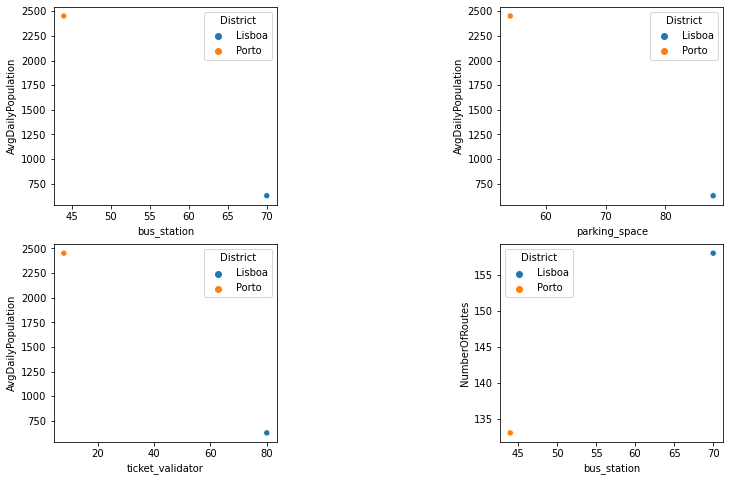

In [223]:
colors = {'Lisboa':'red', 'Porto':'blue'}


fig = plt.figure(2)

ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(x='bus_station', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
sns.scatterplot(x='parking_space', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax2)
ax3 = fig.add_subplot(2, 2, 3)
sns.scatterplot(x='ticket_validator', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax3)
ax4 = fig.add_subplot(2, 2, 4)
sns.scatterplot(x='bus_station', y='NumberOfRoutes', data=amenities_seniors_df, hue='District', ax=ax4)

fig.subplots_adjust(wspace=1)
fig.set_figheight(8)
fig.set_figwidth(12)

From here we can observe that even though Porto has less amenities such as bus stations, there are more seniors travelling on bus in Porto. A city with less stations or less ticket validators does not appear to negativelly impact the ammount of bus travellers. It can be concluded that more bus stations equals more bus routes. However, it would appear that more parking spaces could invite some seniors to either drive or have someone else give them a ride. Of course that more city amenity data would be necessary to validate this data

- Future work:
It could be very interesting to evaluate if currently, transportations already include sufficient support to accomodate people with reduced mobility, as it could be the case of many seniors. Do transports offer an easy way for these people to enter the transport? Are they properly acomodated during the trips? Surveys to people with reduced mobility could be helpul in determining the current state of reduced mobility support and improvement aspects, which could encourage more people to use these transportations.

## Experiments with HERE fleet API

In [96]:
url='https://fleet.ls.hereapi.com/2/calculateroute.json?apikey=P6oFjKdVpXaFr1-yxIFjFY6dzVgkUISDbEnLfu3RDm4'\
 +'&mode=fastest;bus;traffic:disabled&waypoint0=38.76313,-9.14117&waypoint1=38.76305,-9.14188'

url='https://fleet.ls.hereapi.com/2/matchroute.json?apikey=P6oFjKdVpXaFr1-yxIFjFY6dzVgkUISDbEnLfu3RDm4'\
 +'&linkaccess=80216829&routemode=bus&file=UEsDBBQAAAAIANmztEQSwaeZzwAAAM8BAAAQAAAAc2FtcGxlLXRyYWNlLmdweIXPTQuCMBwG8HufQnZv%2F605S0k9djEIungdZjpSJ27kPn6%2BRBgYXcYYv2cPzzG2deU8805L1YSIYoLiaHMsWvv9uBlYowOrZYhKY9oAoO973DOsugJ2hFBIz8k1K%2FNabGWjjWiy%2FJ36ShjVqqITd2lxpmo4XVKgMP6vZaCneKIyYabivzHnr4BhCbb6hoZRpnvMp86L%2BdIapxImRJxiSuh%2Bj5xq7CWY%2Bcz1EaypA10qxlfVjvOl8rxVxfzDQrk%2FFCfLRs7YpOCzA%2BZd49LoBVBLAQIUABQAAAAIANmztEQSwaeZzwAAAM8BAAAQAAAAAAAAAAEAIAAAAAAAAABzYW1wbGUtdHJhY2UuZ3B4UEsFBgAAAAABAAEAPgAAAP0AAAAAAA%3D%3D'

j = requests.get(url).json()
print(j)

{'RouteLinks': [{'functionalClass': 5, 'confidence': 1.0, 'linkId': 25664478, 'mSecToReachLinkFromStart': 2153, 'shape': '51.10178 0.3935 51.10184 0.39329', 'linkLength': 15.98}, {'functionalClass': 4, 'confidence': 1.0, 'linkId': 1022687683, 'mSecToReachLinkFromStart': 3194, 'shape': '51.10184 0.39329 51.10214 0.39345', 'linkLength': 35.21}, {'functionalClass': 4, 'confidence': 1.0, 'linkId': 1022687684, 'mSecToReachLinkFromStart': 7419, 'shape': '51.10214 0.39345 51.10224 0.3935', 'linkLength': 11.66}, {'functionalClass': 4, 'confidence': 1.0, 'linkId': 25664459, 'mSecToReachLinkFromStart': 8818, 'shape': '51.10224 0.3935 51.10232 0.39354', 'linkLength': 9.33}, {'functionalClass': 4, 'confidence': 1.0, 'linkId': 781742854, 'mSecToReachLinkFromStart': 9938, 'shape': '51.10232 0.39354 51.10245 0.39361 51.10255 0.39367', 'linkLength': 27.16}, {'functionalClass': 4, 'confidence': 1.0, 'linkId': 781742855, 'mSecToReachLinkFromStart': 13197, 'shape': '51.10255 0.39367 51.10269 0.39376', 'l